In [1]:
# !pip install cohere datasets numpy

In [2]:
import numpy as np

from datasets import load_dataset

import nltk

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

In [3]:
lang = "simple" #Use the Simple English Wikipedia subset
docs = load_dataset("Cohere/wikipedia-2023-11-embed-multilingual-v3", lang, split="train")

Using the latest cached version of the dataset since Cohere/wikipedia-2023-11-embed-multilingual-v3 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'simple' at /home/shevkunov/.cache/huggingface/datasets/Cohere___wikipedia-2023-11-embed-multilingual-v3/simple/0.0.0/37feace541fadccf70579e9f289c3cf8e8b186d7 (last modified on Fri Jun 28 15:08:23 2024).


In [4]:
len(docs)

646424

In [139]:
from nltk.tokenize import word_tokenize  
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from scipy.stats.stats import spearmanr, pearsonr

import string

from nltk.stem.porter import *

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
nltk_stop_words = set(stopwords.words("english"))

def remove_punctuations(normalized_tokens):
    return [
        word
        for word in normalized_tokens
        if word not in string.punctuation
    ]

def normalizer(sentence):
    tokens = word_tokenize(sentence)

    #Stemming
    stemed_tokens = []
    for word in tokens:
        stemed_tokens.append(stemmer.stem(word))

    #Lemmatization
    nltk_lemma_list = []
    for word in stemed_tokens:
        nltk_lemma_list.append(lemmatizer.lemmatize(word))

        normalized_tokens = []  
    for w in nltk_lemma_list:  
        if w not in nltk_stop_words:  
            normalized_tokens.append(w)

    #Removing the punctuations
    normalized_tokens = remove_punctuations(normalized_tokens)
    return normalized_tokens

/tmp/ipykernel_20050/3367986097.py:5: DeprecationWarning: Please use `spearmanr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import spearmanr, pearsonr
/tmp/ipykernel_20050/3367986097.py:5: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import spearmanr, pearsonr


In [27]:
doc_tokens

[['april',
  'april',
  'apr',
  'fourth',
  'month',
  'year',
  'julian',
  'gregorian',
  'calendar',
  'come',
  'march',
  'may',
  'one',
  'four',
  'month',
  '30',
  'day'],
 ['april',
  'april',
  'alway',
  'begin',
  'day',
  'week',
  'juli',
  'addit',
  'januari',
  'leap',
  'year',
  'april',
  'alway',
  'end',
  'day',
  'week',
  'decemb'],
 ['april',
  'april',
  'come',
  'march',
  'may',
  'make',
  'fourth',
  'month',
  'year',
  'also',
  'come',
  'first',
  'year',
  'four',
  'month',
  '30',
  'day',
  'june',
  'septemb',
  'novemb',
  'later',
  'year'],
 ['april',
  'april',
  'begin',
  'day',
  'week',
  'juli',
  'everi',
  'year',
  'day',
  'week',
  'januari',
  'leap',
  'year',
  'april',
  'end',
  'day',
  'week',
  'decemb',
  'everi',
  'year',
  "'s",
  'last',
  'day',
  'exactli',
  '35',
  'week',
  '245',
  'day',
  'apart'],
 ['april',
  'common',
  'year',
  'april',
  'start',
  'day',
  'week',
  'octob',
  'previou',
  'year',
  '

In [8]:
DOCS_LIMIT = 16384
DOCS_TEST  = 1024
TOKENS_LIMIT = 200

DOCS_TEST_CUTOFF = DOCS_LIMIT - DOCS_TEST

MASTER_WORDS = set(["red"])

In [9]:
import collections

all_tokens = collections.Counter()
doc_tokens = list()
doc_texts  = list()
embs       = list()

for i, doc in enumerate(docs):
    if i >= DOCS_LIMIT:
        break
    doc_id = doc['_id']
    title = doc['title']
    text = doc['text']
    emb = doc['emb']
    
    doc_texts.append(doc["title"] + " " + doc["text"])
    doc_tokens.append(normalizer(doc_texts[-1]))
    all_tokens.update(doc_tokens[-1])
    embs.append(emb)
        
embs = np.array(embs)
        
len(all_tokens), embs.shape

(33044, (16384, 1024))

In [15]:
from sklearn import manifold


tsne = manifold.TSNE(n_components=2, random_state=0)
embs_flat = tsne.fit_transform(embs)

In [17]:
import torch
from matplotlib import pyplot as plt
from torch import nn

from IPython.display import clear_output

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


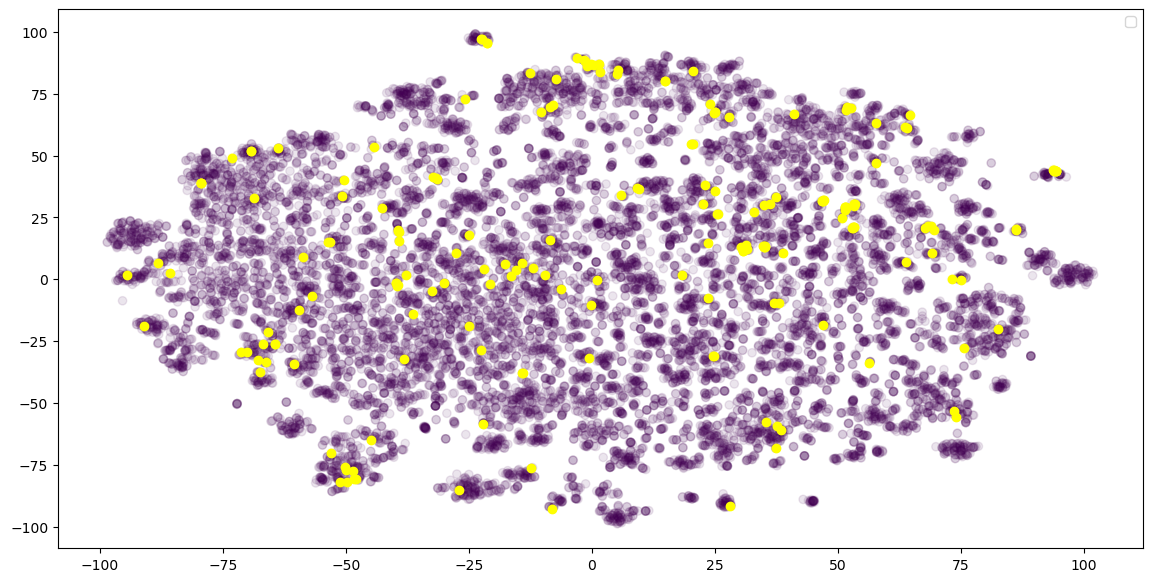

In [29]:
id_2_number_sum = [
    np.sum([token_j in MASTER_WORDS for token_j in doc_tokens_i])
    for doc_tokens_i in doc_tokens
]

id_2_number_avg = [
    np.sum([token_j in MASTER_WORDS for token_j in doc_tokens_i])
    for doc_tokens_i in doc_tokens
]

sorted(id_2_number_sum)[-5:]

plt.figure(figsize=(14, 7))
sl_ = np.array(id_2_number_avg) >= 1
plt.scatter(embs_flat[:, 0], embs_flat[:, 1], alpha=0.1, c=sl_)
plt.scatter(embs_flat[sl_, 0], embs_flat[sl_, 1], alpha=1, c="yellow")
plt.legend()
plt.show()

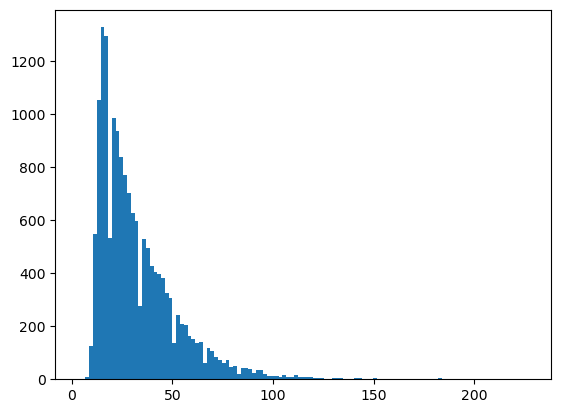

In [141]:
id_2_len = [
    len(doc_tokens_i)
    for doc_tokens_i in doc_tokens
]

plt.hist(id_2_len, bins="auto")
plt.show()

In [142]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

r = Ridge(fit_intercept=True, alpha=0)
r.fit(embs, id_2_len)
mean_squared_error(r.predict(embs), id_2_len) ** 0.5

5.77430543690642

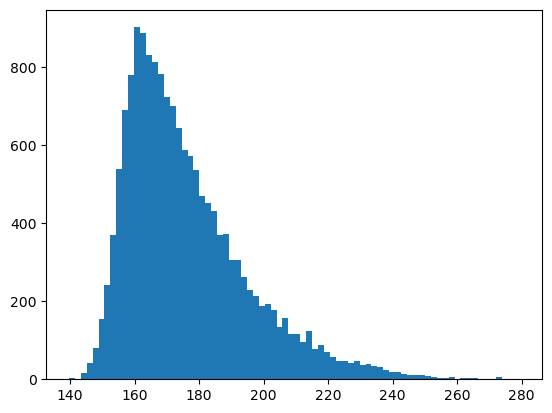

In [143]:
plt.hist(embs @ r.coef_, bins="auto")
plt.show()

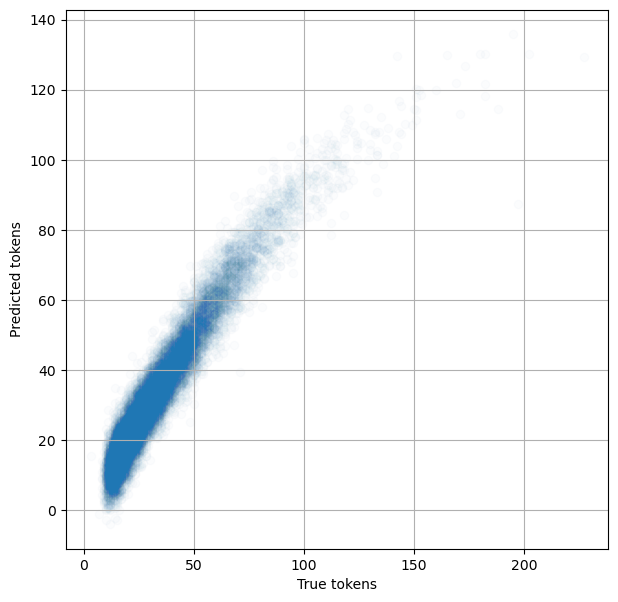

In [144]:
XY = np.array(list(zip(id_2_len, embs @ r.coef_)))
XY = np.array(list(zip(id_2_len, r.predict(embs))))
plt.figure(figsize=(7, 7))
plt.scatter(XY[:, 0], XY[:, 1], alpha=0.015)
plt.xlabel("True tokens")
plt.ylabel("Predicted tokens")
plt.grid()
plt.show()

In [145]:
spearmanr(XY[:, 0], XY[:, 1]), pearsonr(XY[:, 0], XY[:, 1])

(SignificanceResult(statistic=0.9442185852034473, pvalue=0.0),
 PearsonRResult(statistic=0.9567765407613549, pvalue=0.0))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


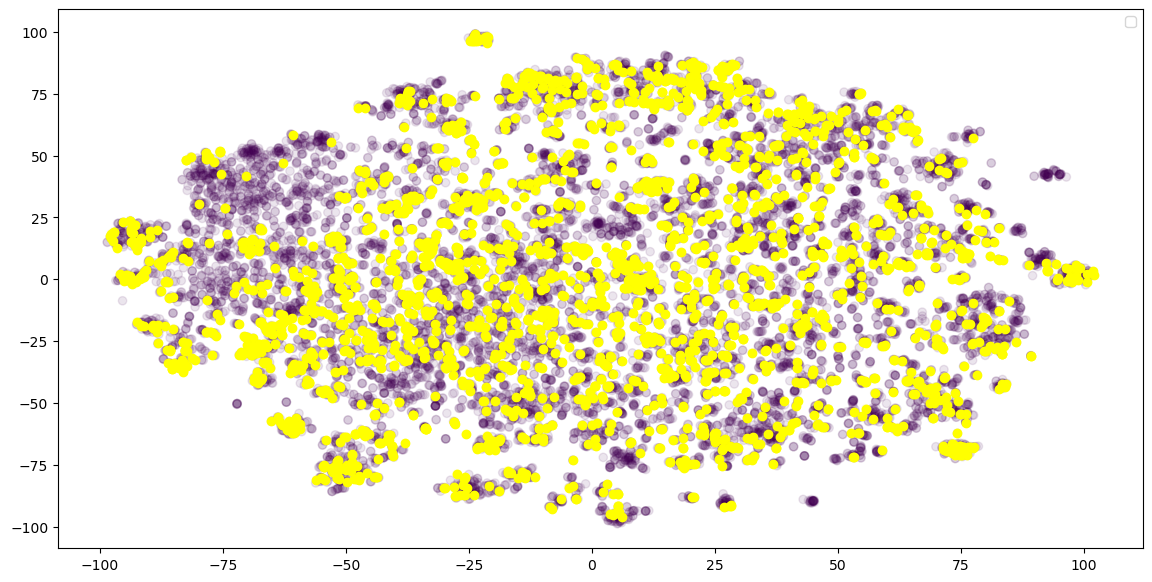

In [33]:




sorted(id_2_number_sum)[-5:]

plt.figure(figsize=(14, 7))
sl_ = np.array(id_2_number_sum) >= 50
plt.scatter(embs_flat[:, 0], embs_flat[:, 1], alpha=0.1, c=sl_)
plt.scatter(embs_flat[sl_, 0], embs_flat[sl_, 1], alpha=1, c="yellow")
plt.legend()
plt.show()

_________________

# Numbers count

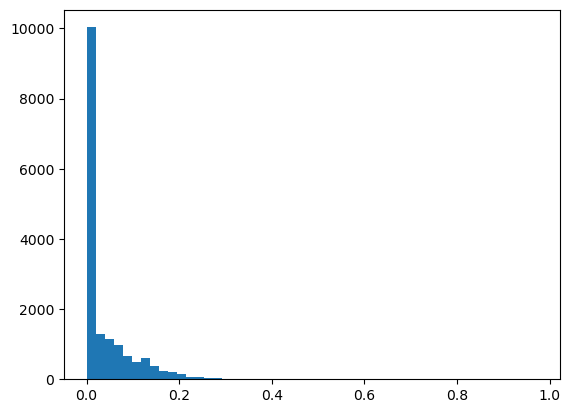

In [107]:
id_2_cnt = [
    np.mean([x.isdigit() for x in doc_tokens_i])
    for doc_tokens_i in doc_tokens
]

plt.hist(id_2_cnt, bins=50)
plt.show()

In [117]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

r = Ridge(fit_intercept=True, alpha=1)
r.fit(embs, id_2_cnt)
mean_squared_error(r.predict(embs), id_2_cnt) ** 0.5

0.03046392393731466

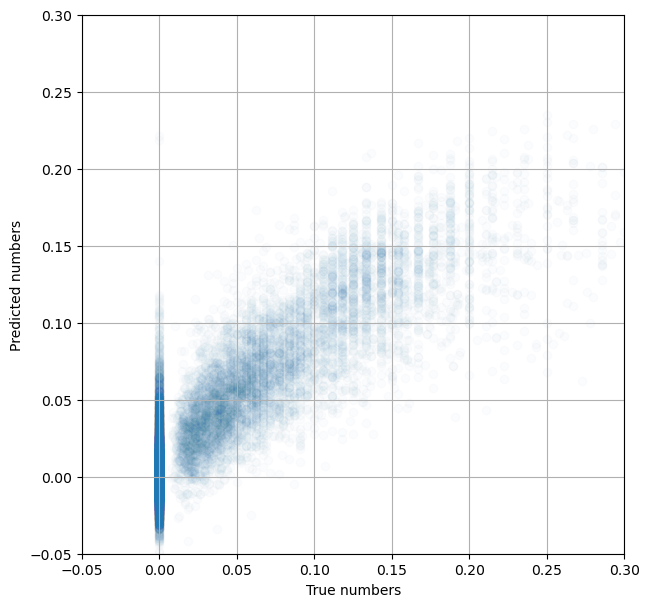

In [118]:
# XY = np.array(list(zip(id_2_len, embs @ r.coef_)))
XY = np.array(list(zip(id_2_cnt, r.predict(embs))))
plt.figure(figsize=(7, 7))
plt.scatter(XY[:, 0], XY[:, 1], alpha=0.015)
l = (-0.05, 0.3)
plt.xlim(l)
plt.ylim(l)
plt.xlabel("True numbers")
plt.ylabel("Predicted numbers")
plt.grid()
plt.show()

In [140]:
spearmanr(XY[:, 0], XY[:, 1]), pearsonr(XY[:, 0], XY[:, 1])

(SignificanceResult(statistic=0.8164969789522649, pvalue=0.0),
 PearsonRResult(statistic=0.8584205497474909, pvalue=0.0))

PearsonRResult(statistic=0.8584205497474909, pvalue=0.0)